In [1]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated, List
from langchain_core.tools import tool

In [2]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]

In [3]:
# tools
@tool
def get_stock_price(company: str) -> str:
    """
    Returns the current stock price for the given company.
    Args:
        company (str): The company name to look up.
    returns:
        The current stock price.
    """
    return {
        "Microsoft": 423.37,
        "Apple": 269.96,
        "Google": 344.90,
        "Amazon": 242.96,
        "Nvidia": 185.61,
        "Meta": 706.41,
    }.get(company.capitalize(), "Company not found")


tools = [get_stock_price]

In [4]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud").bind_tools(tools=tools)

In [5]:
def chatbot(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])

    return {"messages": response}

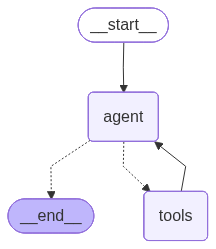

In [6]:
graph = StateGraph(AgentState)

graph.add_node("agent", chatbot)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.add_edge(START, "agent")

# tool condition edge
graph.add_conditional_edges("agent", tools_condition)

# now it will become agentic
graph.add_edge("tools", "agent")

graph.add_edge("agent", END)

app = graph.compile()
app

In [7]:
user_input = "i have bought 20 shares of apple then 15 of microsoft. what is the total of it?\n and also tell me what is the stock price of nvidia today"

response = app.invoke({
    "messages": [{"role": "user", "content": user_input}]
})

In [8]:
response["messages"]

[HumanMessage(content='i have bought 20 shares of apple then 15 of microsoft. what is the total of it?\n and also tell me what is the stock price of nvidia today', additional_kwargs={}, response_metadata={}, id='2beeace0-6e0e-4b6f-a0be-61a596f45bea'),
 AIMessage(content="I can help you get the current stock prices, but I need to clarify something about your portfolio calculation.\n\nTo calculate the total value of your portfolio, I need the current stock prices for both Apple and Microsoft. Let me get those prices for you, along with Nvidia's current price:", additional_kwargs={}, response_metadata={'model': 'deepseek-v3.1:671b-cloud', 'created_at': '2026-02-03T17:20:16.201997565Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2083422856, 'load_duration': None, 'prompt_eval_count': 204, 'prompt_eval_duration': None, 'eval_count': 101, 'eval_duration': None, 'logprobs': None, 'model_name': 'deepseek-v3.1:671b-cloud', 'model_provider': 'ollama'}, id='lc_run--019c21f2-48de-7d20-

In [9]:
print(response["messages"][-1].content)

Now I can calculate your portfolio value:

**Your Portfolio:**
- Apple: 20 shares × $269.96 = $5,399.20
- Microsoft: 15 shares × $423.37 = $6,350.55
- **Total Portfolio Value: $11,749.75**

**Current Stock Price of Nvidia:**
- Nvidia: $185.61

So your total portfolio value is $11,749.75, and Nvidia is currently trading at $185.61 per share.
